### Flight Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = (SparkSession.builder.master("local[*]").appName("Final_Project").getOrCreate())
sc = spark.sparkContext
import pandas as pd

In [2]:
file_path = '2021.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [3]:
df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+-----------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+--------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Year|Quarter|M

In [4]:
column_subset = [
    "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]

flight_data = df[column_subset]
type = flight_data.dtypes
describe = flight_data.describe().toPandas()
type,describe

([('FlightDate', 'date'),
  ('Airline', 'string'),
  ('Tail_Number', 'string'),
  ('Flight_Number_Marketing_Airline', 'int'),
  ('Origin', 'string'),
  ('Dest', 'string'),
  ('Cancelled', 'boolean'),
  ('Diverted', 'boolean'),
  ('CRSDepTime', 'int'),
  ('DepTime', 'double'),
  ('DepDelayMinutes', 'double'),
  ('OriginAirportID', 'int'),
  ('OriginCityName', 'string'),
  ('OriginStateName', 'string'),
  ('DestAirportID', 'int'),
  ('DestCityName', 'string'),
  ('DestStateName', 'string'),
  ('TaxiOut', 'double'),
  ('TaxiIn', 'double'),
  ('CRSArrTime', 'int'),
  ('ArrTime', 'double'),
  ('ArrDelayMinutes', 'double')],
   summary                      Airline Tail_Number  \
 0   count                      6311871     6288568   
 1    mean                         None        None   
 2  stddev                         None        None   
 3     min  Air Wisconsin Airlines Corp       206NV   
 4     max        United Air Lines Inc.      n714FR   
 
   Flight_Number_Marketing_Airline   Orig

In [5]:
flight_data.show(10)

+----------+--------------------+-----------+-------------------------------+------+----+---------+--------+----------+-------+---------------+---------------+--------------------+---------------+-------------+--------------------+-------------+-------+------+----------+-------+---------------+
|FlightDate|             Airline|Tail_Number|Flight_Number_Marketing_Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|OriginAirportID|      OriginCityName|OriginStateName|DestAirportID|        DestCityName|DestStateName|TaxiOut|TaxiIn|CRSArrTime|ArrTime|ArrDelayMinutes|
+----------+--------------------+-----------+-------------------------------+------+----+---------+--------+----------+-------+---------------+---------------+--------------------+---------------+-------------+--------------------+-------------+-------+------+----------+-------+---------------+
|2021-03-03|SkyWest Airlines ...|     N728SK|                           3133|   SGU| PHX|    false|   false|    

In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
flight_data.registerTempTable('flight')


c:\Users\21706\anaconda3\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
c:\Users\21706\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [7]:
sqlContext.sql('''SELECT count(*) from flight
                ''').show()

+--------+
|count(1)|
+--------+
| 6311871|
+--------+



In [8]:
sqlContext.sql('''SELECT Airline, Tail_Number, DepDelayMinutes
               FROM flight
               WHERE DepDelayMinutes < 30
                ''').show()

#Distribution plot can be drawn by this.

+--------------------+-----------+---------------+
|             Airline|Tail_Number|DepDelayMinutes|
+--------------------+-----------+---------------+
|SkyWest Airlines ...|     N728SK|            0.0|
|SkyWest Airlines ...|     N752SK|            0.0|
|SkyWest Airlines ...|     N766SK|            0.0|
|SkyWest Airlines ...|     N752EV|            0.0|
|SkyWest Airlines ...|     N715SK|            0.0|
|SkyWest Airlines ...|     N744SK|            0.0|
|SkyWest Airlines ...|     N727SK|            0.0|
|SkyWest Airlines ...|     N771SK|            0.0|
|SkyWest Airlines ...|     N614SK|            0.0|
|SkyWest Airlines ...|     N773SK|            0.0|
|SkyWest Airlines ...|     N762SK|            2.0|
|SkyWest Airlines ...|     N730SK|            0.0|
|SkyWest Airlines ...|     N741EV|            8.0|
|SkyWest Airlines ...|     N716SK|            0.0|
|SkyWest Airlines ...|     N631SK|            0.0|
|SkyWest Airlines ...|     N772SK|            0.0|
|SkyWest Airlines ...|     N716

Delays are divided into three categories, namely "on time or small delay" (up to 15 minutes delay), "Medium delay" (15 – 45 minutes delay) and "Large delay" ( 45 minutes delay).

In [9]:
from pyspark.sql.functions import when

flight_data_with_group =  flight_data.withColumn(
    "Delay_Group",
    when(flight_data["DepDelayMinutes"] == 0, "On_time")
    .when(flight_data["DepDelayMinutes"] <= 15, "Small_delay")
    .when((flight_data["DepDelayMinutes"] > 15) & (flight_data["DepDelayMinutes"] <= 45), "Medium_delay")
    .when(flight_data["DepDelayMinutes"] > 45, "Large_delay")
    .when(flight_data["Cancelled"] == True, "Cancelled")
)

flight_data_with_group.show(10)



+----------+--------------------+-----------+-------------------------------+------+----+---------+--------+----------+-------+---------------+---------------+--------------------+---------------+-------------+--------------------+-------------+-------+------+----------+-------+---------------+-----------+
|FlightDate|             Airline|Tail_Number|Flight_Number_Marketing_Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|OriginAirportID|      OriginCityName|OriginStateName|DestAirportID|        DestCityName|DestStateName|TaxiOut|TaxiIn|CRSArrTime|ArrTime|ArrDelayMinutes|Delay_Group|
+----------+--------------------+-----------+-------------------------------+------+----+---------+--------+----------+-------+---------------+---------------+--------------------+---------------+-------------+--------------------+-------------+-------+------+----------+-------+---------------+-----------+
|2021-03-03|SkyWest Airlines ...|     N728SK|                           3133

In [10]:
flight_data_with_group.registerTempTable('flight_group')

sqlContext.sql('''SELECT COUNT(Tail_Number) AS Flight_Num, Delay_Group
               FROM flight_group
               GROUP BY Delay_Group
               ORDER BY Flight_Num DESC
                ''').show()

#The numbuer of flight in each delay group

+----------+------------+
|Flight_Num| Delay_Group|
+----------+------------+
|   4147768|     On_time|
|   1019416| Small_delay|
|    563238|Medium_delay|
|    473036| Large_delay|
|     85110|   Cancelled|
+----------+------------+



In [11]:
sqlContext.sql('''SELECT 
               Delay_Group, 
               COUNT(Tail_Number) AS Flight_Num,
               (COUNT(Tail_Number) / SUM(COUNT(Tail_Number)) OVER ()) * 100 AS Percentage
               FROM flight_group
               GROUP BY Delay_Group
               ORDER BY Flight_Num DESC
                ''').show()

#Percentage of each group, can draw a pie chart based on that.

+------------+----------+------------------+
| Delay_Group|Flight_Num|        Percentage|
+------------+----------+------------------+
|     On_time|   4147768| 65.95727357961304|
| Small_delay|   1019416|16.210622195704968|
|Medium_delay|    563238| 8.956538277076753|
| Large_delay|    473036| 7.522157667691595|
|   Cancelled|     85110|1.3534082799136464|
+------------+----------+------------------+



In [12]:
sqlContext.sql('''SELECT Airline, count(Tail_Number) as Flight_Num
               FROM flight_group
               GROUP BY Airline
               ORDER BY Flight_Num DESC
                ''').show()

#The numbuer of delayed flight in each airline.
#We can split it more specific with 'group by delay group'.
#See chart 'https://www.kaggle.com/code/robikscube/flight-delay-exploratory-data-analysis-twitch' chuck [21] "Top Airlines Flight Result Breakdown"

+--------------------+----------+
|             Airline|Flight_Num|
+--------------------+----------+
|Southwest Airline...|   1061633|
|SkyWest Airlines ...|    753305|
|Delta Air Lines Inc.|    747859|
|American Airlines...|    735991|
|United Air Lines ...|    440872|
|   Republic Airlines|    332646|
|   Endeavor Air Inc.|    266862|
|           Envoy Air|    255533|
|         Comair Inc.|    222385|
|     JetBlue Airways|    202687|
|    Spirit Air Lines|    191361|
|Alaska Airlines Inc.|    188955|
|  Mesa Airlines Inc.|    159005|
|Frontier Airlines...|    135281|
|       Allegiant Air|    112764|
|         Horizon Air|    111628|
|Capital Cargo Int...|     99188|
|Air Wisconsin Air...|     77943|
|Commutair Aka Cha...|     74219|
|Hawaiian Airlines...|     60293|
+--------------------+----------+
only showing top 20 rows



In [13]:
sqlContext.sql('''SELECT Airline, count(Tail_Number) as Flight_Cancelled
               FROM flight_group
               WHERE Cancelled = 'True'
               GROUP BY Airline
               ORDER BY Flight_Cancelled DESC
               ''').show()

+--------------------+----------------+
|             Airline|Flight_Cancelled|
+--------------------+----------------+
|Southwest Airline...|           20498|
|American Airlines...|           16070|
|SkyWest Airlines ...|           13285|
|    Spirit Air Lines|            5661|
|           Envoy Air|            5468|
|   Republic Airlines|            5367|
|  Mesa Airlines Inc.|            3979|
|Delta Air Lines Inc.|            3492|
|     JetBlue Airways|            3284|
|Alaska Airlines Inc.|            3217|
|         Horizon Air|            2096|
|         Comair Inc.|            2037|
|Capital Cargo Int...|            1180|
|   Endeavor Air Inc.|             969|
|       Allegiant Air|             712|
|United Air Lines ...|             142|
|Air Wisconsin Air...|              96|
|Frontier Airlines...|              68|
|Commutair Aka Cha...|              42|
|GoJet Airlines, L...|              37|
+--------------------+----------------+
only showing top 20 rows



In [14]:
df=flight_data

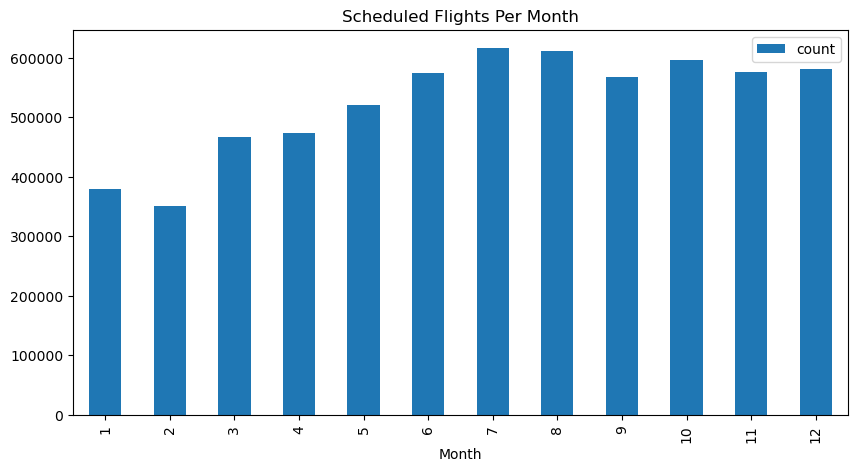

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month
import matplotlib.pyplot as plt

flight_data2 = flight_data.withColumn("Month", month("FlightDate"))

# 按月统计航班次数
month_counts = flight_data2.groupBy("Month").count().orderBy("Month")

pdf = month_counts.toPandas()

pdf.plot(kind="bar", x='Month', y='count', figsize=(10, 5), title="Scheduled Flights Per Month")
plt.show()




In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, col, count, sum
from pyspark.sql import functions as F

flight_data_with_group2 = flight_data_with_group.withColumn("Month", month("FlightDate"))

df_agg = flight_data_with_group2.groupBy("Month", "Delay_Group").count().withColumnRenamed("count", "group_count")

total_flights_per_month = flight_data_with_group2.groupBy("Month").count().withColumnRenamed("count", "total_count")

df_agg = df_agg.join(total_flights_per_month, "Month")

df_agg = df_agg.withColumn("Percentage", (col("group_count") / col("total_count")) * 100)

df_pivot = df_agg.groupBy("Month").pivot("Delay_Group").sum("Percentage")

col_order = ["On_time", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_final = df_pivot.select(["Month"] + col_order)


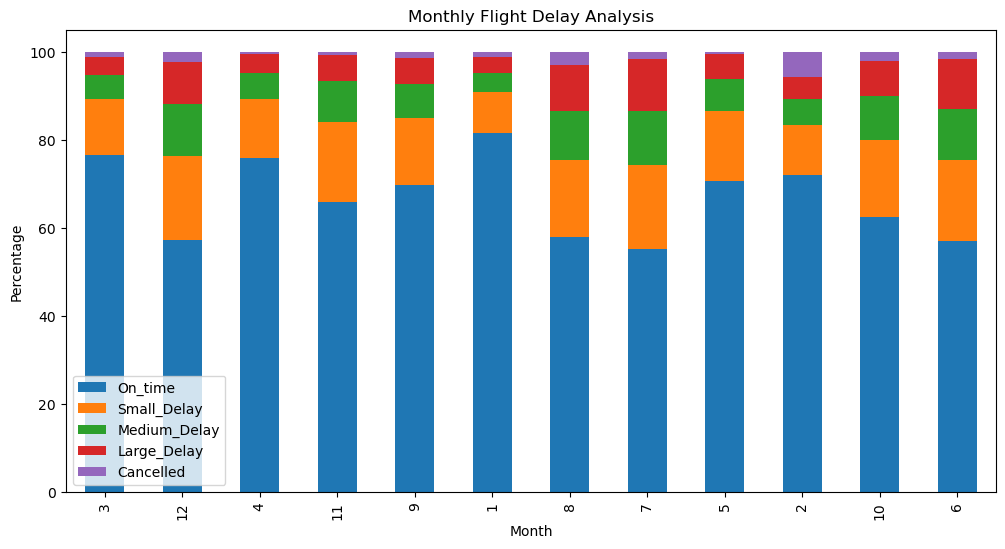

In [17]:
import matplotlib.pyplot as plt

df_pandas = df_final.toPandas()
df_pandas.plot(kind='bar', x='Month', stacked=True, figsize=(12, 6))
plt.title("Monthly Flight Delay Analysis")
plt.xlabel("Month")
plt.ylabel("Percentage")
plt.show()


In [18]:
#航空公司

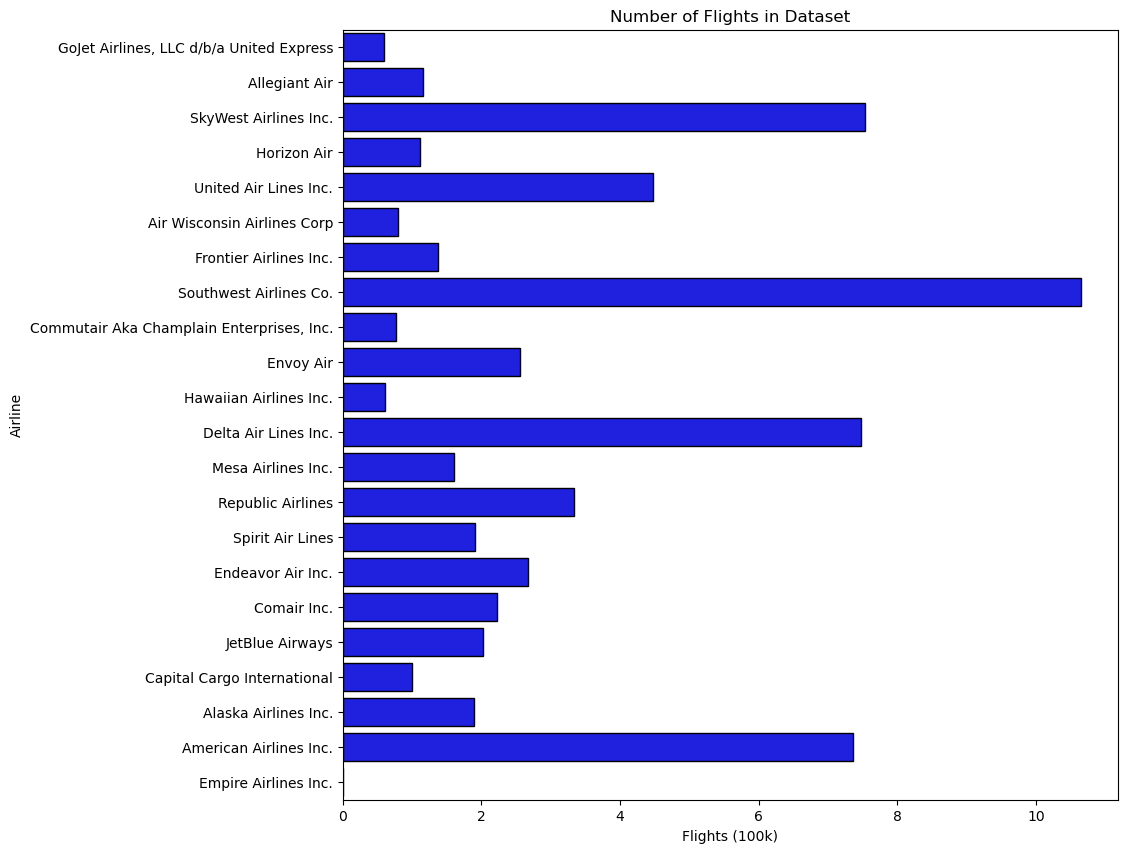

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
airline_counts = flight_data_with_group2.groupBy("Airline").count()
airline_counts_pandas = airline_counts.toPandas()
airline_counts_pandas['count'] = airline_counts_pandas['count'] / 100_000
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='count', y='Airline', data=airline_counts_pandas, ax=ax, color="blue", edgecolor="black")
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

plt.show()



In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, lit
import matplotlib.pyplot as plt
import pandas as pd

airline_counts = flight_data_with_group2.groupBy("Airline").count()
top_airlines =['SkyWest Airlines Inc.','Southwest Airlines Co.','American Airlines Inc.','Delta Air Lines Inc.','United Air Lines Inc.']


df_top = flight_data_with_group2.filter(col("Airline").isin(top_airlines))


df_agg = df_top.groupBy("Airline").pivot("Delay_Group").count()

total_count = df_agg.select([count(lit(1)).alias('total')]).collect()[0]['total']
for col_name in df_agg.columns[1:]:
    df_agg = df_agg.withColumn(col_name, (col(col_name) / total_count) * 100)

df_agg_pandas = df_agg.toPandas().set_index("Airline")
df_agg_pandas







,Cancelled,Large_delay,Medium_delay,On_time,Small_delay
Airline,,,,,
SkyWest Airlines Inc.,262400.0,1146640.0,937560.0,11107060.0,1613200.0
United Air Lines Inc.,119300.0,630560.0,782640.0,5656100.0,1748140.0
Southwest Airlines Co.,466780.0,1935680.0,3433040.0,9684820.0,5772480.0
Delta Air Lines Inc.,70500.0,684300.0,987440.0,10694460.0,2523260.0
American Airlines Inc.,322000.0,1235660.0,1282560.0,9452680.0,2435080.0


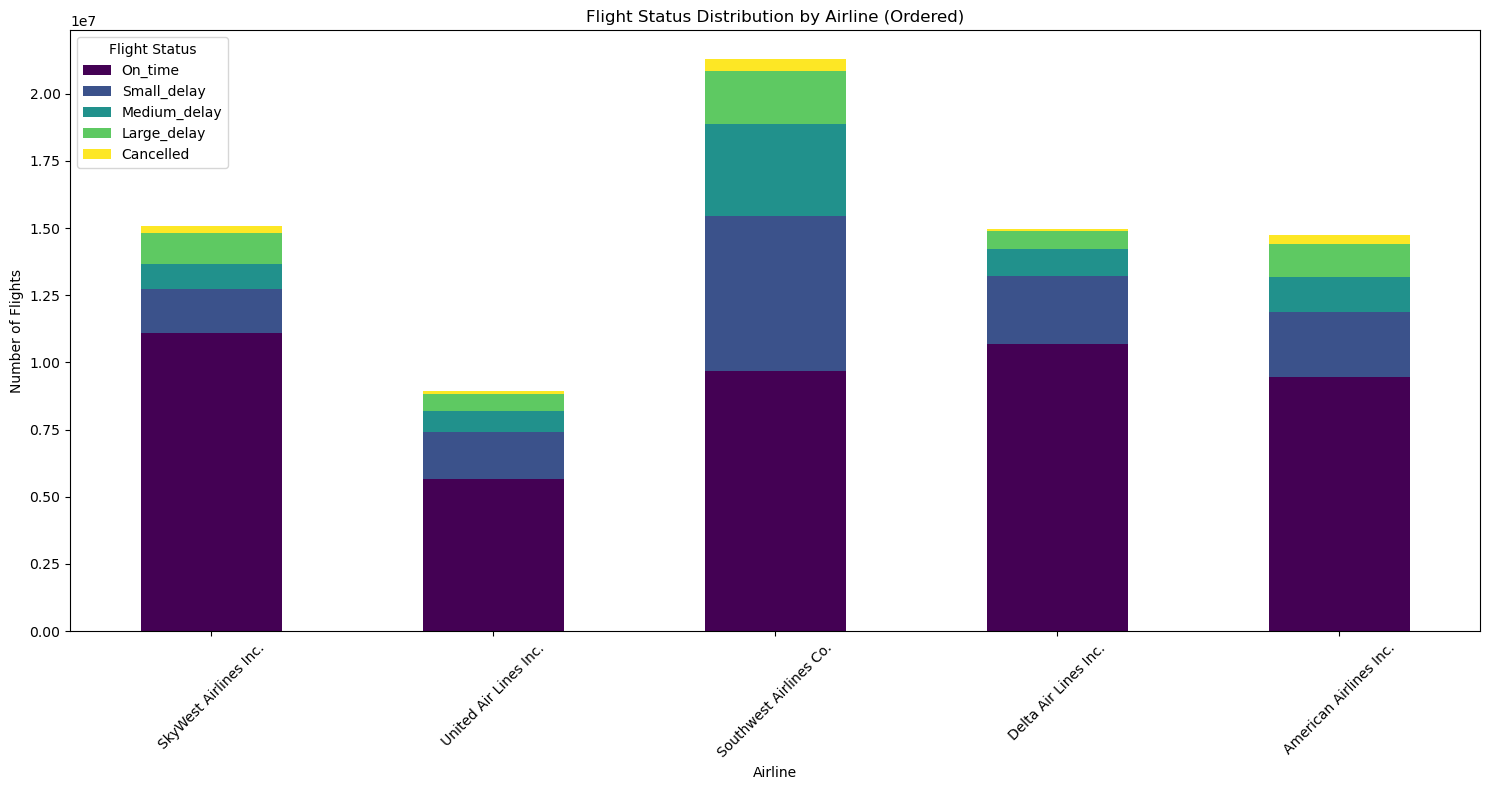

In [21]:

ordered_columns = ["On_time", "Small_delay", "Medium_delay", "Large_delay", "Cancelled"]
df_ordered = df_agg_pandas[ordered_columns]
ax = df_ordered.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')
plt.title('Flight Status Distribution by Airline (Ordered)')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Flight Status', loc='upper left')
plt.tight_layout()

plt.show()

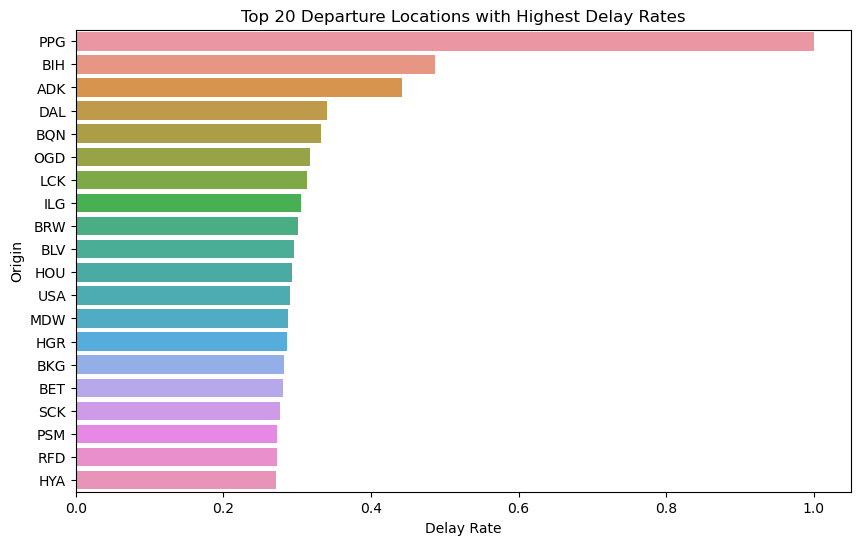

In [22]:

delays = flight_data_with_group2.withColumn("IsDelayed", when(col("DepDelayMinutes") > 15, 1).otherwise(0))
delay_counts = delays.groupBy("Origin").agg(
    count("FlightDate").alias("TotalFlights"),
    sum("IsDelayed").alias("DelayedFlights")
)

delay_rates = delay_counts.withColumn("DelayRate", col("DelayedFlights") / col("TotalFlights"))

delay_rates_pandas = delay_rates.toPandas()

delay_rates_pandas = delay_rates_pandas.sort_values(by="DelayRate", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="DelayRate", y="Origin", data=delay_rates_pandas.head(20)) 
plt.title("Top 20 Departure Locations with Highest Delay Rates")
plt.xlabel("Delay Rate")
plt.ylabel("Origin")
plt.show()

In [23]:
delay_rates_pandas = delay_counts.toPandas()

In [24]:
delay_rates_pandas

,Origin,TotalFlights,DelayedFlights
0,INL,642,67
1,DLG,480,93
2,MSY,37634,6506
3,GEG,19693,2260
4,DRT,661,58
...,...,...,...
375,MVY,1011,260
376,WYS,479,69
377,LNY,28,4
378,MKK,28,3


In [25]:
ppg_flights = delay_rates_pandas[delay_rates_pandas['Origin'] == 'PPG']
ppg_flights

,Origin,TotalFlights,DelayedFlights
367,PPG,6,6


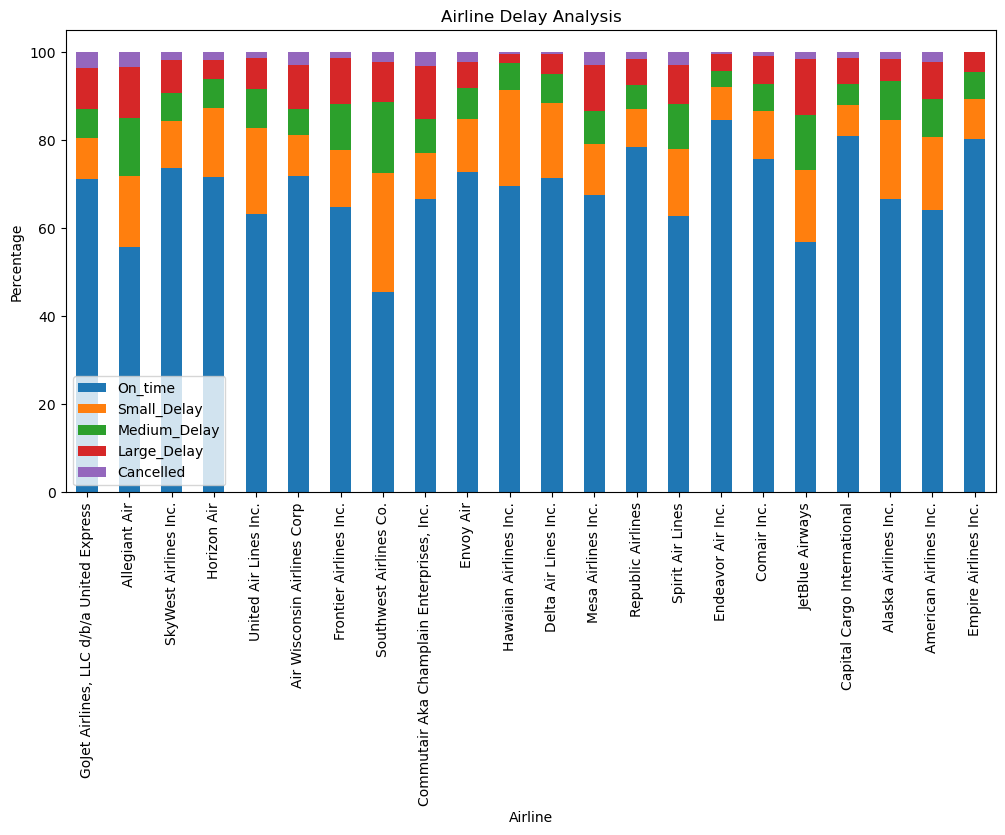

In [26]:
df_agg2 = flight_data_with_group2.groupBy("Airline", "Delay_Group").count().withColumnRenamed("count", "group_count")

total_flights_per_airline = flight_data_with_group2.groupBy("Airline").count().withColumnRenamed("count", "total_count")

df_agg2 = df_agg2.join(total_flights_per_airline, "Airline")

df_agg2 = df_agg2.withColumn("Percentage_airline", (col("group_count") / col("total_count")) * 100)

df_pivot2 = df_agg2.groupBy("Airline").pivot("Delay_Group").sum("Percentage_airline")


df_final2 = df_pivot2.select(["Airline"] + col_order)


df_pandas = df_final2.toPandas()
df_pandas.plot(kind='bar', x='Airline', stacked=True, figsize=(12, 6))
plt.title("Airline Delay Analysis")
plt.xlabel("Airline")
plt.ylabel("Percentage")
plt.show()

Random Forest

In [28]:
df = spark.read.option('header','true').csv("2021.csv",inferSchema = True)

Data preparation

In [29]:
df= df.select('DepDel15','Month','Distance','Operating_Airline','Operated_or_Branded_Code_Share_Partners','OriginAirportID','OriginStateFips','DestAirportID','DestStateFips')
from pyspark.sql.functions import when, col
df = df.withColumn('Operated_or_Branded_Code_Share_Partners', 
                            when(col('Operated_or_Branded_Code_Share_Partners').contains('CODESHARE'), 1).otherwise(0))
from pyspark.ml.feature import StringIndexer
indexer1=StringIndexer(inputCol='Operating_Airline',outputCol='Operating_Airline_cat')
indexer2=StringIndexer(inputCol='OriginAirportID',outputCol='OriginAirportID_cat')
indexer3=StringIndexer(inputCol='DestAirportID',outputCol='DestAirportID_cat')
indexed=indexer1.fit(df).transform(df)
indexed=indexer2.fit(indexed).transform(indexed)
indexed=indexer3.fit(indexed).transform(indexed)


from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["Month","Distance","Operated_or_Branded_Code_Share_Partners","OriginStateFips","DestStateFips",'Operating_Airline_cat'], outputCol= "features")

output = assembler.transform(indexed)
output = output.filter(~col('DepDel15').contains('NULL'))


Model fitting

In [30]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="DepDel15", numTrees=10)

train_data, test_data = output.randomSplit([0.7, 0.3])

rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="DepDel15", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.83


In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="DepDel15", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
mse

0.17272686301946072